In [1]:
import pandas as pd
import numpy as np
from scipy import stats

### 1
В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

Измерены следующие признаки:

- state — штат США


- account_length — длительность использования аккаунта


- area_code — деление пользователей на псевдорегионы, использующееся в телекоме


- intl_plan — подключена ли у пользователя услуга международного общения


- vmail_plan — подключена ли у пользователя услуга голосовых сообщений


- vmail_message — количество голосых сообщений, который пользователь отправил / принял


- day_calls — сколько пользователь совершил дневных звонков


- day_mins — сколько пользователь проговорил минут в течение дня


- day_charge — сколько пользователь заплатил за свою дневную активность


- eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности


- night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности


- intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения


- custserv_calls — сколько раз пользователь позвонил в службу поддержки


- treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)


- mes_estim — оценка интенсивности пользования интернет мессенджерами


- churn — результат оттока: перестал ли абонент пользоваться услугами оператора


Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.


Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции


**scipy.stats.chi2_contingency(subtable, correction=False)**


Заметьте, что, например, (AZ, HI) и (HI, AZ) — это одна и та же пара. Обязательно выставьте correction=False (о том, что это значит, вы узнаете из следующих вопросов).

Сколько достигаемых уровней значимости оказались меньше, чем $\alpha=0.05$?

In [2]:
from itertools import combinations

In [3]:
df = pd.read_csv("churn_analysis.csv")
df.drop(df.columns[0], inplace=True, axis=1)
df.churn = df.churn.map({"True.": True, "False.": False})

In [4]:
_ = {"no": False, "yes": True}
df.vmail_plan = df.vmail_plan.map(_)
df.intl_plan = df.intl_plan.map(_)

In [5]:
pt_states = pd.pivot_table(df.loc[df.treatment == 1], values='treatment',
                           index='state', columns='churn', aggfunc=len, fill_value=0)

In [6]:
pt_states.index

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='state')

In [76]:
def create_table(input_table, method, correction=None):
    result = pd.DataFrame(columns=['state 1', 'state 2', 'stat', 'p'])
    
    for i, (st1, st2) in enumerate(combinations(input_table.index, 2)):
        table = input_table.loc[[st1, st2],:]
        if not correction is None:
            stat, p, _, _, = method(table, correction=correction)
        else:
            stat, p = method(table)
        
        result.loc[i, 'state 1'] = st1
        result.loc[i, 'state 2'] = st2
        result.loc[i, 'stat'] = stat
        result.loc[i, 'p'] = p
        
    return result
        

In [70]:
%%time
res_1 = create_table(pt_states,stats.chi2_contingency, False)

Wall time: 3.5 s


In [53]:
(res_1.p < 0.05).sum()

34

----
### 2
Какие проблемы Вы видите в построении анализа из первого вопроса? Отметьте все верные утверждения.


- Интерпретация числа достигаемых уровней значимости, меньших $\alpha=0.05$, некорректна, поскольку не сделана поправка на множественную проверку гипотез. **+**


- Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия, при которых этот критерий дает правильные результаты. **+**



In [54]:
(create_table(pt_states, True).p < 0.05).sum()

0

---
### 3
В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного $O_i$ и ожидаемого $E_i$ значений, то есть, статистика с такой поправкой выглядит так:

$$\chi^2_{Yates}=\sum\limits_{i=1}^{N}\frac{(|O_i−E_i|−0.5)^2}{E_i}$$

Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики $\chi^2$, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией


**scipy.stats.chi2_contingency(subtable, correction=True)**


и сравните полученные результаты, отметив все верные варианты.

---

- Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно из значений достигаемого уровня значимости не попадает в диапазон от 0 до 0.05. +


- Достигаемые уровни значимости на наших данных, полученные с помощью критерия xи-квадрат с поправкой Йетса, в среднем получаются больше, чем соответствующие значения без поправки. 


---
### 4
Что если у нас мало данных, мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно ?

В таком случае прибегают к так называемому точному критерию Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Пусть у нас есть таблица сопряженности 2x2:

$ $	| Группа 1	| Группа 2 | $\sum$
:--- | --- | --- | :- | 
Воздействие 1 |	$a$ |	$b$ |	$a + b$ |
Воздействие 2 |	$c$ |	$d$	| $c + d$|
$\sum$ |	$a + c$ | $b + d$ | $n = a + b + c + d$ |

Тогда вероятность получить именно такие $a, b, c, d$ при фиксированных значениях сумм по строкам и по столбцам) задается выражением

$$\large p = \frac{\binom{a+b}{a}\binom{c + d}{c}}{\binom{n}{a+c}} = \frac{(a+b)! \space (c+d)! \space (a+c)! \space (b+d)!}{a! \space b! \space c! \space d! \space n!} $$

В числителе этой дроби стоит суммарное количество способов выбрать $a$ и $c$ из $a + b$ и $c + d$ соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца $a + c$ из общего количества рассматриваемых объектов $n$.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения $a, b, c, d$ в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора $a, b, c, d$ нужно вычислить значение $p_i$ по формуле выше и просуммировать все такие значения $p_i$, которые меньше или равны $p$, которое мы вычислили по наблюдаемым значениям $a, b, c, d$.

Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы $n\times m$.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

Точный критерий Фишера удобно вычислять с помощью функции


**scipy.stats.fisher_exact**


которая принимает на вход таблицу сопряженности 2x2.

---

- Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля. 


- Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем значительно большие, чем xи-квадрат без поправки 


- Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости в среднем меньшие, чем xи-квадрат с поправкой Йетса 



In [77]:
res_4 = create_table(pt_states, stats.fisher_exact)

In [78]:
res_4.head()

,state 1,state 2,stat,p
0,AK,AL,3.8,0.381063
1,AK,AR,8.63636,0.0688616
2,AK,AZ,2.23529,0.60499
3,AK,CA,9.5,0.0639647
4,AK,CO,5.58824,0.187034


In [80]:
(res_4.p < 0.05).sum()

10

---
### 5
Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость.

Отметьте все верные утверждения.

- Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо.

In [88]:
val, p = stats.pearsonr(df.day_calls, df.mes_estim)
print("Pear  value:", val)
print("p:", p)

Pear  value: -0.051794350587572625
p: 0.0027798836869738384


---
### 6
Еще раз рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

Отметьте все верные утверждения.


- Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне доверия 0.05 значимо. +


In [89]:
stats.spearmanr(df.day_calls, df.mes_estim)

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

---
### 7
Как можно интерпретировать полученные значения коэффициентов корреляции и достигаемые уровни значимости при проверки гипотез о равенстве нулю этих коэффициентов?


- Посчитанные корреляции и их значимости говорят лишь о том, что необходимо взглянуть на данные глазами и попытаться понять, что приводит к таким (противоречивым?) результатам. 

3 

In [95]:
df.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,False,True,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False
1,OH,107,415,False,True,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False
2,NJ,137,415,False,False,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False
3,OH,84,408,True,False,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False
4,OK,75,415,True,False,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False


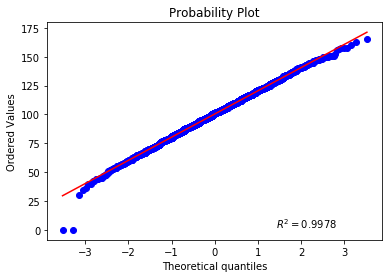

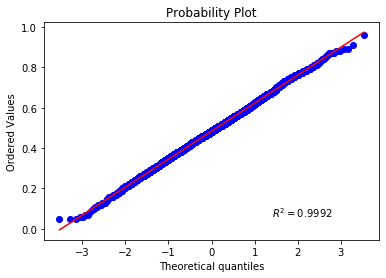

In [94]:
import matplotlib.pyplot as plt

stats.probplot(df.day_calls, plot=plt, rvalue=True);
plt.show()
stats.probplot(df.mes_estim, plot=plt, rvalue=True);

---
### 8
Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?


- Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, на которую мы не можем положиться применительно к нашим данным.


In [97]:
pt_states.head()

churn,False,True
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [104]:
def cramer_p(confusion_matrix):
    chi2, p = stats.chi2_contingency(confusion_matrix)[:2]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1))), p

In [105]:
cramer_p(pt_states.values)

(0.2003932150203332, 0.7097590042778473)

---
### 9
Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение.

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

_Не забудьте про поправку на множественную проверку! И не пользуйтесь односторонними альтернативами, поскольку вы не знаете, к каким действительно последствиям приводят тестируемые методы (treatment = 0, treatment = 2) !_


- treatment = 2 статистически значимо отличается от контрольной группы treatment = 1


-  Отличие между treatment = 0 и treatment = 2 относительно влияния на уровень churn статистически незначимо.



In [106]:
df.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,False,True,25,265.1,110,45.07,197.4,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False
1,OH,107,415,False,True,26,161.6,123,27.47,195.5,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False
2,NJ,137,415,False,False,0,243.4,114,41.38,121.2,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False
3,OH,84,408,True,False,0,299.4,71,50.90,61.9,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False
4,OK,75,415,True,False,0,166.7,113,28.34,148.3,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False
